# DATA SCRAPING&PROCESSING
## data scraping
Ouputs:
* ecb_urls_dates.csv #for date
* ecb_monetary_policy_statements_all_years.csv
* ecb_statement_qna_raw.csv
* ecb_statement_qna_cleaned.csv



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

base_path = "/content/ECB_project"

folders = [
    "data/raw_html",
    "data/raw_text",
    "data/processed",
    "src",
    "logs"
]

for folder in folders:
    os.makedirs(os.path.join(base_path, folder), exist_ok=True)


In [ ]:
#!pip install requests beautifulsoup4 pandas

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from datetime import datetime

In [ ]:
# scrape_ecb_urls.py
# Robust (no selenium here):
#   1) requests main archive page
#   2) extract yearly snippet URLs from data-snippets
#   3) requests each snippet page and collect statement links
#   4) fetch each statement page and get meeting_date + title

import re
import time
from urllib.parse import urljoin, urlparse
import requests
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm

BASE = "https://www.ecb.europa.eu"
INDEX_URL = "https://www.ecb.europa.eu/press/press_conference/monetary-policy-statement/html/index.en.html"
HEADERS = {"User-Agent": "Mozilla/5.0"}

def parse_date_from_is_url(url: str) -> str | None:
    """
    Supports:
      .../html/is000203.en.html
      .../html/is030508_1.en.html
      .../html/ecb.is251218~hash.en.html
    """
    m = re.search(r"(?:/|\.)(?:ecb\.)?is(\d{2})(\d{2})(\d{2})(?:[_~].*)?\.en\.html$", url)
    if not m:
        return None
    yy, mm, dd = map(int, m.groups())
    year = 1900 + yy if yy >= 90 else 2000 + yy
    return f"{year:04d}-{mm:02d}-{dd:02d}"

def is_ecb_domain(url: str) -> bool:
    p = urlparse(url)
    return (p.netloc == "" or p.netloc.endswith("ecb.europa.eu"))

def fetch_soup(url: str) -> BeautifulSoup:
    r = requests.get(url, headers=HEADERS, timeout=40)
    r.raise_for_status()
    return BeautifulSoup(r.content, "html.parser")

def extract_title(soup: BeautifulSoup) -> str | None:
    """
    Prefer og:title (usually clean), then <title>, then first <h1>.
    """
    og = soup.find("meta", {"property": "og:title"})
    if og and og.get("content"):
        return og["content"].strip()

    t = soup.find("title")
    if t and t.get_text(strip=True):
        return t.get_text(strip=True)

    h1 = soup.find("h1")
    if h1 and h1.get_text(strip=True):
        return h1.get_text(strip=True)

    return None

def url_priority(u: str) -> int:
    """
    Lower score = preferred.
    Picks the 'canonical' page if multiple URLs share the same date.
    """
    score = 0
    if "~" in u:
        score += 10
    if re.search(r"_\d+\.en\.html$", u):  # isYYMMDD_1.en.html etc.
        score += 5
    if "ecb.is" in u:       # newer hashed patterns
        score += 3
    return score

def main():
    print("Fetching index page…", flush=True)
    index_soup = fetch_soup(INDEX_URL)

    dl = index_soup.find("dl", id="lazyload-container")
    if dl is None or not dl.has_attr("data-snippets"):
        raise RuntimeError("Could not find data-snippets on the index page.")

    snippets_raw = dl["data-snippets"]
    snippet_paths = [s.strip() for s in snippets_raw.split(",") if s.strip()]
    snippet_urls = [urljoin(INDEX_URL, p) for p in snippet_paths]

    # keep only 1999+
    snippet_urls_1999 = []
    for u in snippet_urls:
        m = re.search(r"/(\d{4})/html/index_include\.en\.html$", u)
        if m and int(m.group(1)) >= 1999:
            snippet_urls_1999.append(u)

    print(f"Keeping {len(snippet_urls_1999)} snippet pages for 1999+.", flush=True)

    all_statement_urls = set()

    for u in tqdm(snippet_urls_1999, desc="Downloading snippet pages"):
        try:
            soup = fetch_soup(u)

            for a in soup.find_all("a", href=True):
                href = a["href"].strip()
                full = urljoin(BASE, href)

                if not is_ecb_domain(full):
                    continue
                if "/press/press_conference/monetary-policy-statement/" not in full:
                    continue
                if not full.endswith(".en.html"):
                    continue

                all_statement_urls.add(full)

        except Exception as e:
            print(f"\nFailed snippet: {u} | {e}", flush=True)

        time.sleep(0.05)

    all_statement_urls = sorted(all_statement_urls)
    print(f"\nCollected {len(all_statement_urls)} statement URLs (1999+ snippets).", flush=True)

    df = pd.DataFrame({"url": all_statement_urls})

    meeting_dates = []
    titles = []

    for url in tqdm(df["url"], desc="Extracting dates + titles"):
        date = None
        title = None

        try:
            page = fetch_soup(url)

            # date: meta published_time if available
            meta = page.find("meta", {"property": "article:published_time"})
            if meta and meta.get("content"):
                dt = pd.to_datetime(meta["content"], errors="coerce")
                if pd.notna(dt):
                    date = dt.strftime("%Y-%m-%d")

            # title
            title = extract_title(page)

        except Exception:
            pass

        if not date:
            date = parse_date_from_is_url(url)

        meeting_dates.append(date)
        titles.append(title)

        time.sleep(0.05)

    df["meeting_date"] = meeting_dates
    df["title"] = titles

    # keep 1999+
    out = df.dropna(subset=["meeting_date"]).copy()
    out = out[out["meeting_date"] >= "1999-01-01"].copy()

    # choose one row per date
    out["prio"] = out["url"].apply(url_priority)
    out = (
        out.sort_values(["meeting_date", "prio", "url"])
           .drop_duplicates(subset=["meeting_date"], keep="first")
           .drop(columns=["prio"])
           .sort_values("meeting_date")
           .reset_index(drop=True)
    )

    out_path = "ecb_urls_dates.csv"
    out[["meeting_date", "url", "title"]].to_csv(out_path, index=False)

    print("\nSaved:", out_path, flush=True)
    print("Rows:", len(out), flush=True)
    if len(out):
        print("Earliest:", out["meeting_date"].iloc[0], flush=True)
        print("Latest:", out["meeting_date"].iloc[-1], flush=True)

if __name__ == "__main__":
    main()


Fetching index page…
Keeping 27 snippet pages for 1999+.



Collected 285 statement URLs (1999+ snippets).



Extracting dates + titles: 100%|██████████| 285/285 [02:37<00:00,  1.81it/s]


Saved: ecb_urls_dates.csv
Rows: 282
Earliest: 1999-01-07
Latest: 2025-12-18


In [ ]:
import pandas as pd

df = pd.read_csv("ecb_urls_dates.csv")

df["meeting_date"] = df["meeting_date"].astype(str).str.strip()

df["meeting_date"] = pd.to_datetime(
    df["meeting_date"],
    errors="coerce",
    dayfirst=True,
    format="mixed"
)

print("Unparsed rows:", df["meeting_date"].isna().sum())


Unparsed rows: 0


In [ ]:
df["title_lower"] = df["title"].astype(str).str.lower()

keep_pattern = r"(introductory statement|monetary policy statement)"
drop_pattern = r"(transcript|opening|signing|agreement|exhibition|balance of payments|design|assessment)"

df_clean = df[
    df["title_lower"].str.contains(keep_pattern, regex=True, na=False) &
    ~df["title_lower"].str.contains(drop_pattern, regex=True, na=False)
].copy()


/tmp/ipython-input-2378790882.py:7: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df["title_lower"].str.contains(keep_pattern, regex=True, na=False) &
/tmp/ipython-input-2378790882.py:8: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  ~df["title_lower"].str.contains(drop_pattern, regex=True, na=False)


In [ ]:
df_clean = (
    df_clean.sort_values(["meeting_date", "url"])
            .drop_duplicates(subset=["meeting_date"], keep="first")
            .reset_index(drop=True)
)


In [ ]:
print("Total meetings:", len(df_clean))
print(df_clean.groupby(df_clean["meeting_date"].dt.year).size())


Total meetings: 274
meeting_date
1999    11
2000    13
2001    11
2002    11
2003    12
2004    11
2005    11
2006    12
2007    11
2008    12
2009    12
2010    12
2011    12
2012    12
2013    12
2014    12
2015     8
2016     8
2017     7
2018     8
2019     8
2020     8
2021     8
2022     8
2023     8
2024     8
2025     8
dtype: int64


In [ ]:
df_clean[["meeting_date","url","title"]].to_csv(
    "ecb_monetary_policy_statements_all_years.csv",
    index=False
)


In [ ]:
import re
import csv
import pandas as pd
import requests
from bs4 import BeautifulSoup

HEADERS = {"User-Agent": "Mozilla/5.0"}

JUNK_LINE_RE = re.compile(
    r"(?im)^\s*(jump to the transcript of the questions and answers|with the transcript of the questions and answers)\s*$"
)

TRANSCRIPT_START_RE = re.compile(r"(?im)^\s*transcript of the questions.*$")
QNA_HEADING_RE = re.compile(r"(?im)^\s*(questions and answers|q\s*&\s*a|q&a)\s*$")
QUESTION_PREFIX_RE = re.compile(r"(?im)^\s*question\s*:")

SPOKEN_MARKERS = [
    "we are now ready to take your questions",
    "we are now ready for your questions",
    "we are now at your disposal for questions",
    "i will now take your questions",
]

def download_html(url: str) -> str:
    r = requests.get(url, headers=HEADERS, timeout=40)
    r.raise_for_status()
    r.encoding = r.apparent_encoding
    return r.text

def extract_title(soup: BeautifulSoup) -> str:
    h1 = soup.find("h1")
    if h1 and h1.get_text(strip=True):
        return h1.get_text(" ", strip=True)
    if soup.title and soup.title.get_text(strip=True):
        return soup.title.get_text(" ", strip=True)
    return ""

def extract_main_text(soup: BeautifulSoup) -> str:
    main = soup.find("main")
    article = main.find("article") if main else None
    node = article or main or soup.body or soup

    for tag in node.find_all(["script", "style", "nav", "header", "footer", "aside"]):
        tag.decompose()

    text = node.get_text(separator="\n")
    text = re.sub(r"\r", "\n", text)
    text = re.sub(r"\n{3,}", "\n\n", text)
    return text.strip()

def remove_junk_lines(text: str) -> str:
    lines = text.split("\n")
    lines = [ln for ln in lines if not JUNK_LINE_RE.match(ln.strip())]
    return "\n".join(lines).strip()

def split_statement_qna_whole(text: str):
    text = remove_junk_lines(text)
    lines = text.split("\n")

    def find_line_index(pattern_re):
        for i, ln in enumerate(lines):
            if pattern_re.match(ln.strip()):
                return i
        return None

    i = find_line_index(TRANSCRIPT_START_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    i = find_line_index(QNA_HEADING_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    i = find_line_index(QUESTION_PREFIX_RE)
    if i is not None:
        return "\n".join(lines[:i]).strip(), "\n".join(lines[i:]).strip()

    low = text.lower()
    for m in SPOKEN_MARKERS:
        idx = low.find(m)
        if idx != -1:
            return text[:idx].strip(), text[idx:].strip()

    return text.strip(), ""

def scrape_one(url: str):
    html = download_html(url)
    soup = BeautifulSoup(html, "html.parser")

    title = extract_title(soup)
    main_text = extract_main_text(soup)
    statement, qa = split_statement_qna_whole(main_text)

    return title, statement, qa

def excel_safe_multiline(s: str) -> str:
    """
    Replace real newlines inside a cell with the literal characters \n
    so Excel doesn't display them as extra rows when opening CSV.
    """
    if s is None:
        return ""
    s = s.replace("\r\n", "\n").replace("\r", "\n")
    return s.replace("\n", r"\n")

def scrape_statements():
    url_index_path = "ecb_monetary_policy_statements_all_years.csv"
    df = pd.read_csv(url_index_path)

    if "meeting_date" not in df.columns or "url" not in df.columns:
        raise ValueError("Your driver CSV must have columns: meeting_date, url")

    out = []
    for _, row in df.iterrows():
        meeting_date = str(row["meeting_date"])[:10]
        url = row["url"]

        try:
            title, statement, qa = scrape_one(url)
        except Exception as e:
            print(f"[FAIL] {meeting_date} {url} -> {e}")
            title = statement = qa = ""

        out.append({
            "meeting_date": meeting_date,
            "url": url,
            "title": title,
            "statement_text": excel_safe_multiline(statement),
            "qa_text": excel_safe_multiline(qa),
        })

    out_df = pd.DataFrame(out)

    out_df.to_csv(
        "ecb_statement_qna_raw.csv",
        index=False,
        quoting=csv.QUOTE_ALL
    )

    print("Saved: ecb_statement_qna_raw.csv")
    print("Rows:", len(out_df))

if __name__ == "__main__":
    scrape_statements()


Saved: ecb_statement_qna_raw.csv
Rows: 274


In [ ]:
import pandas as pd
import re

# load raw csv
df = pd.read_csv("ecb_statement_qna_raw.csv", dtype=str)

# turn \n back into real newlines
for col in ["statement_text", "qa_text"]:
    df[col] = df[col].fillna("").str.replace(r"\n", "\n", regex=False)

# STATEMENT CLEANING
def clean_statement(s):
    lines = [ln.strip() for ln in s.split("\n") if ln.strip()]

    # remove ECB title line
    if lines and lines[0].lower().startswith("ecb press conference"):
        lines = lines[1:]

    # remove generic headers
    drop_re = re.compile(
        r"^(ecb|european central bank).*press conference$|"
        r"^monetary policy statement$|"
        r"^introductory statement$",
        re.I
    )

    while lines and drop_re.match(lines[0]):
        lines.pop(0)

    return "\n".join(lines)


# Q&A CLEANING
def clean_qa(q):
    lines = [ln.strip() for ln in q.split("\n") if ln.strip()]

    lines = [
        ln for ln in lines
        if not re.match(r"^transcript of the questions", ln, re.I)
    ]

    return "\n".join(lines)

df["statement_text_clean"] = df["statement_text"].apply(clean_statement)
df["qa_text_clean"] = df["qa_text"].apply(clean_qa)

# flatten tabs to spaces (removes \n in the file)
for col in ["statement_text_clean", "qa_text_clean"]:
    df[col] = (df[col]
               .astype(str)
               .str.replace(r"[\r\n\t]+", " ", regex=True)
               .str.replace(r"\s+", " ", regex=True)
               .str.strip())


# export
df.to_csv("ecb_statement_qna_cleaned.csv", index=False)

print("Saved: ecb_statement_qna_cleaned.csv")
print("Rows:", len(df))


Saved: ecb_statement_qna_cleaned.csv
Rows: 274


# Tokenisation (texte → mots propres)

In [ ]:
# Prepare dates and sort

import pandas as pd

df = df.copy()

# create date from meeting_date
df["date"] = pd.to_datetime(df["meeting_date"], errors="coerce")

df = df.dropna(subset=["date"]).sort_values("date").reset_index(drop=True)

print("Date range:", df["date"].min(), "→", df["date"].max())
df[["date"]].head()


Date range: 1999-01-07 00:00:00 → 2025-12-18 00:00:00


,date
0,1999-01-07
1,1999-02-04
2,1999-03-04
3,1999-04-08
4,1999-05-06


In [ ]:
# Tokenize text (stopwords + Porter stemming)

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import PorterStemmer

nltk.download("stopwords")

STOP_WORDS = set(stopwords.words("english"))
tokenizer = RegexpTokenizer(r"[a-zA-Z]+")
stemmer = PorterStemmer()

def tokenize(text: str):
    if pd.isna(text):
        return []
    tokens = tokenizer.tokenize(str(text).lower())
    tokens = [stemmer.stem(t) for t in tokens if t not in STOP_WORDS]
    return tokens

print(tokenize(df.loc[0, "statement_text_clean"])[:30])


['willem', 'f', 'duisenberg', 'presid', 'european', 'central', 'bank', 'thursday', 'januari', 'ladi', 'gentlemen', 'vice', 'presid', 'today', 'report', 'outcom', 'first', 'meet', 'govern', 'council', 'european', 'central', 'bank', 'stage', 'three', 'econom', 'monetari', 'union', 'first', 'time']


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Build bigram sets

from nltk.util import bigrams

def bigram_set(text: str):
    """
    Convert text -> tokens -> set of bigrams
    Uses tokenize() from previous cell (stopwords + Porter stem) exactly once.
    """
    tokens = tokenize(text)
    if len(tokens) < 2:
        return set()
    return set(bigrams(tokens))

# Check
print(list(bigram_set(df.loc[0, "statement_text_clean"]))[:10])


[('council', 'today'), ('recent', 'monetari'), ('monetari', 'develop'), ('confirm', 'intent'), ('start', 'system'), ('januari', 'observ'), ('polici', 'decis'), ('even', 'januari'), ('optimist', 'outlook'), ('today', 'decis')]


In [ ]:
# Jaccard similarity

def jaccard(A: set, B: set) -> float:
    if not A or not B:
        return 0.0
    return len(A & B) / len(A | B)

# Quick test
A = {("ecb","press"), ("press","conference")}
B = {("ecb","press"), ("central","bank")}
print(jaccard(A, B))  # expected: 1 / 3 = 0.333...


0.3333333333333333


In [ ]:
# Check before splitting samples

required_cols = ["date", "statement_text_clean", "qa_text_clean"]
missing = [c for c in required_cols if c not in df.columns]

print("Missing columns:", missing)
print("df shape:", df.shape)

# Ensure date is datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
print("date min/max:", df["date"].min(), "→", df["date"].max())
print("NaT dates:", df["date"].isna().sum())

# Sort
df = df.sort_values("date").reset_index(drop=True)
df.head(3)


Missing columns: []
df shape: (274, 8)
date min/max: 1999-01-07 00:00:00 → 2025-12-18 00:00:00
NaT dates: 0


,meeting_date,url,title,statement_text,qa_text,statement_text_clean,qa_text_clean,date
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...",Question: The teething problems that you menti...,1999-01-07
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...",Question: ... this extension of the period of ...,1999-02-04
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...","Question (translation) : Mr. President, what, ...",1999-03-04


In [ ]:
# Build bigram sets
if "bigrams_statement" not in df.columns:
    df["bigrams_statement"] = df["statement_text_clean"].apply(bigram_set)

if "bigrams_qa" not in df.columns:
    df["bigrams_qa"] = df["qa_text_clean"].apply(bigram_set)

df[["date", "bigrams_statement", "bigrams_qa"]].head(2)


,date,bigrams_statement,bigrams_qa
0,1999-01-07,"{(council, today), (recent, monetari), (moneta...","{(import, contact), (presid, duisenberg), (lar..."
1,1999-02-04,"{(car, sale), (output, growth), (council, toda...","{(right, fairli), (dollar, rate), (make, diffi..."


In [ ]:
# Split samples (Replication vs Extension)

df_all = df.sort_values("date").reset_index(drop=True).copy()

df_9913 = df_all[(df_all["date"] >= "1999-01-01") & (df_all["date"] <= "2013-12-31")].copy()
df_9925 = df_all[(df_all["date"] >= "1999-01-01") & (df_all["date"] <= "2025-12-31")].copy()

print("Replication sample 1999–2013:", df_9913["date"].min(), "→", df_9913["date"].max(), "| n =", len(df_9913))
print("Extension sample 1999–2025:", df_9925["date"].min(), "→", df_9925["date"].max(), "| n =", len(df_9925))


Replication sample 1999–2013: 1999-01-07 00:00:00 → 2013-12-05 00:00:00 | n = 175
Extension sample 1999–2025: 1999-01-07 00:00:00 → 2025-12-18 00:00:00 | n = 274


In [ ]:
# Quick check: unique dates
print("9913 unique dates:", df_9913["date"].is_unique)
print("9925 unique dates:", df_9925["date"].is_unique)


9913 unique dates: True
9925 unique dates: True


Apply the similarity function separately to each sample
to avoid look-ahead bias and ensure a strict replication


In [ ]:
#Compute similarity series within a sample

import pandas as pd

def compute_similarity_series_from_sets(sets_series):
    """
    Compute Jaccard similarity between consecutive documents
    within a given sample.
    """
    similarities = [pd.NA]  # first document has no previous one
    for i in range(1, len(sets_series)):
        prev_set = sets_series.iloc[i-1]
        curr_set = sets_series.iloc[i]

        if prev_set is None or curr_set is None:
            similarities.append(pd.NA)
        elif len(prev_set) == 0 and len(curr_set) == 0:
            similarities.append(pd.NA)
        else:
            similarities.append(jaccard(prev_set, curr_set))

    return similarities


In [ ]:
# Replication sample (1999–2013): statement similarity

df_9913 = df_9913.sort_values("date").reset_index(drop=True)

df_9913["statement_similarity"] = compute_similarity_series_from_sets(
    df_9913["bigrams_statement"]
)

# First 10 rows
df_9913[["date", "statement_similarity"]].head(10)


,date,statement_similarity
0,1999-01-07,<NA>
1,1999-02-04,0.123596
2,1999-03-04,0.156379
3,1999-04-08,0.096007
4,1999-05-06,0.097046
5,1999-06-02,0.131094
6,1999-07-15,0.096269
7,1999-09-09,0.086277
8,1999-10-07,0.107773
9,1999-11-04,0.094368


In [ ]:
df_9913["statement_similarity"].dropna().describe()


,statement_similarity
count,174.000000
unique,174.000000
top,0.123596
freq,1.000000


In [ ]:
# Force similarity column to numeric (for stats & regressions)

df_9913["statement_similarity"] = pd.to_numeric(
    df_9913["statement_similarity"], errors="coerce"
)

df_9913["statement_similarity"].describe()


,statement_similarity
count,174.000000
mean,0.240921
std,0.124572
min,0.008556
25%,0.133206
50%,0.220151
75%,0.342066
max,0.546305


In [ ]:
# Extension sample (1999–2025): statement similarity

df_9925 = df_9925.sort_values("date").reset_index(drop=True)

df_9925["statement_similarity"] = compute_similarity_series_from_sets(
    df_9925["bigrams_statement"]
)

df_9925["statement_similarity"] = pd.to_numeric(
    df_9925["statement_similarity"], errors="coerce"
)

df_9925["statement_similarity"].describe()


,statement_similarity
count,273.000000
mean,0.290545
std,0.141717
min,0.008556
25%,0.167665
50%,0.296167
75%,0.392924
max,0.640805


Extending the sample to 2025, we find that the average similarity of ECB introductory statements increases from 0.24 in the replication period (1999–2013) to 0.29, suggesting a continued standardization of ECB communication beyond the original sample.

#Q&A similarity (1999–2013)

In [ ]:
# Replication sample (1999–2013): Q&A similarity

df_9913["qa_similarity"] = compute_similarity_series_from_sets(
    df_9913["bigrams_qa"]
)

df_9913["qa_similarity"] = pd.to_numeric(
    df_9913["qa_similarity"], errors="coerce"
)

df_9913["qa_similarity"].describe()


,qa_similarity
count,174.000000
mean,0.041493
std,0.007369
min,0.000000
25%,0.037772
50%,0.042273
75%,0.046167
max,0.056609


While ECB introductory statements exhibit substantial textual continuity, Q&A sessions remain much more heterogeneous, reflecting their interactive and less scripted nature.

#Q&A similarity (1999–2025)

In [ ]:
# Extension sample (1999–2025): Q&A similarity

df_9925["qa_similarity"] = compute_similarity_series_from_sets(
    df_9925["bigrams_qa"]
)

df_9925["qa_similarity"] = pd.to_numeric(
    df_9925["qa_similarity"], errors="coerce"
)

df_9925["qa_similarity"].describe()


,qa_similarity
count,273.000000
mean,0.041604
std,0.007577
min,0.000000
25%,0.038200
50%,0.042507
75%,0.046150
max,0.058386


In contrast, the similarity of Q&A sessions remains very low (around 0.04) and stable over time, highlighting the inherently heterogeneous and interactive nature of this communication channel.

In [ ]:
# export similarity 99-23
sim_9913 = df_9913[["meeting_date", "statement_similarity", "qa_similarity"]].copy()
sim_9913 = sim_9913.sort_values("meeting_date")
sim_9913.to_csv("similarity_1999_2013.csv", index=False)
# Now until 25
sim_9925 = df_9925[["meeting_date", "statement_similarity", "qa_similarity"]].copy()
sim_9925 = sim_9925.sort_values("meeting_date")
sim_9925.to_csv("similarity_1999_2025.csv", index=False)


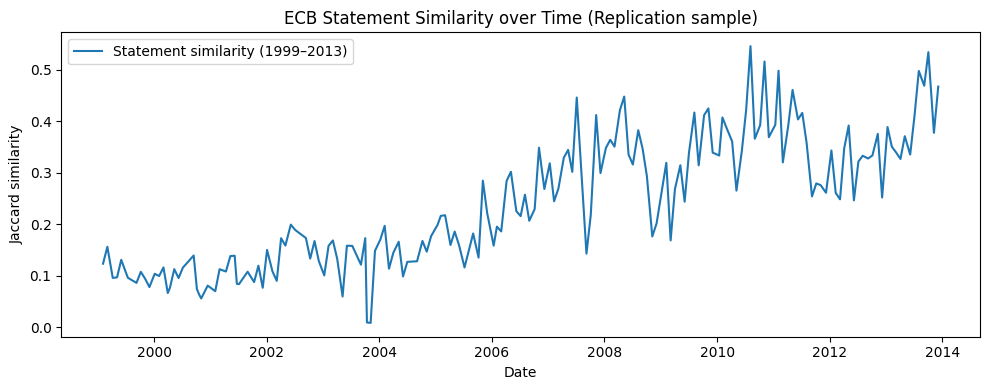

In [ ]:
import matplotlib.pyplot as plt

# Plot statement similarity over time - Replication sample (1999–2013)
plt.figure(figsize=(10,4))
plt.plot(df_9913["date"], df_9913["statement_similarity"], label="Statement similarity (1999–2013)")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Statement Similarity over Time (Replication sample)")
plt.legend()
plt.tight_layout()
plt.show()


The upward trend in statement similarity suggests an increasing standardization of ECB communication, consistent with the learning hypothesis emphasized by Amaya and Filbien (2015).

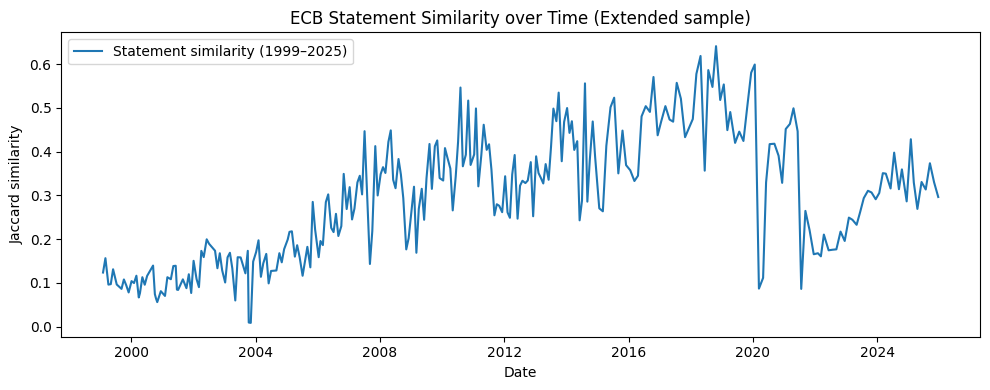

In [ ]:
# Plot statement similarity over time - Extension sample (1999–2025)

plt.figure(figsize=(10,4))
plt.plot(df_9925["date"], df_9925["statement_similarity"], label="Statement similarity (1999–2025)")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Statement Similarity over Time (Extended sample)")
plt.legend()
plt.tight_layout()
plt.show()


While statement similarity increases steadily until the mid-2010s, we observe a sharp drop around 2020, consistent with the unprecedented nature of the COVID-19 shock. Post-2020, similarity partially recovers but remains below pre-crisis levels, suggesting a more adaptive communication strategy

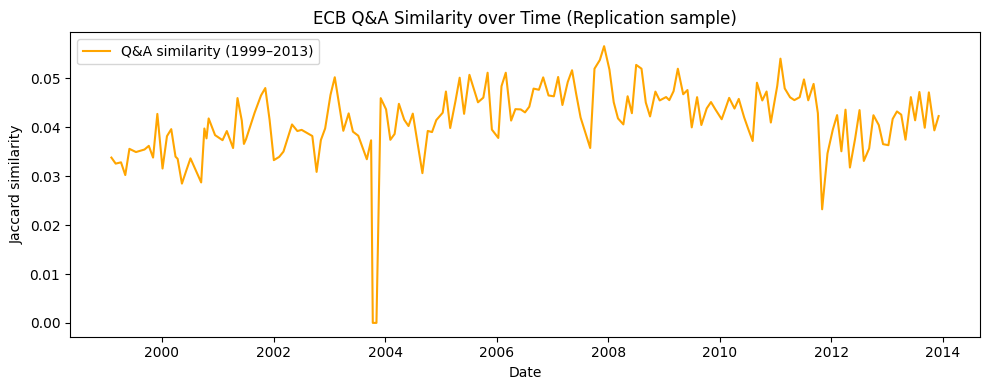

In [ ]:
# Plot Q&A similarity over time — Replication sample (1999–2013)

plt.figure(figsize=(10,4))
plt.plot(df_9913["date"], df_9913["qa_similarity"], label="Q&A similarity (1999–2013)", color="orange")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Q&A Similarity over Time (Replication sample)")
plt.legend()
plt.tight_layout()
plt.show()


Unlike introductory statements, Q&A sessions exhibit low and stable similarity, reflecting their interactive and unscripted nature

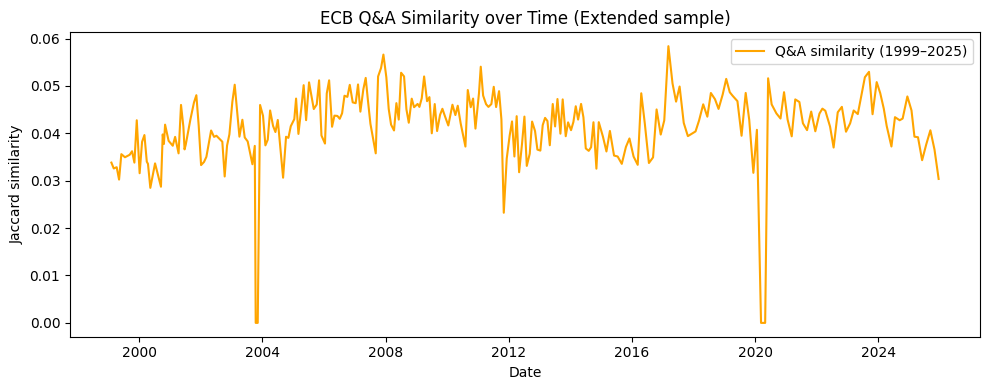

In [ ]:
# Plot Q&A similarity over time — Extension sample (1999–2025)

plt.figure(figsize=(10,4))
plt.plot(df_9925["date"], df_9925["qa_similarity"], label="Q&A similarity (1999–2025)", color="orange")
plt.xlabel("Date")
plt.ylabel("Jaccard similarity")
plt.title("ECB Q&A Similarity over Time (Extended sample)")
plt.legend()
plt.tight_layout()
plt.show()


While the similarity of ECB introductory statements increases markedly over time, the similarity of Q&A sessions remains low and stable even in the extended sample, confirming the fundamentally interactive nature of this communication channel.

/tmp/ipython-input-3485360494.py:6: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


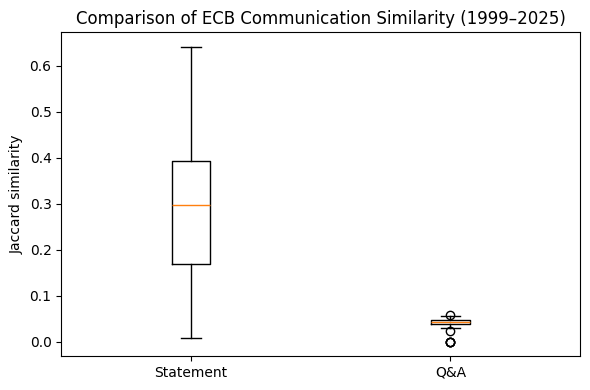

In [ ]:
# Boxplot comparison: Statement vs Q&A similarity (1999–2025)

import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.boxplot(
    [
        df_9925["statement_similarity"].dropna(),
        df_9925["qa_similarity"].dropna()
    ],
    labels=["Statement", "Q&A"],
    showfliers=True
)

plt.ylabel("Jaccard similarity")
plt.title("Comparison of ECB Communication Similarity (1999–2025)")
plt.tight_layout()
plt.show()


### Summary of similarity analysis

We find strong evidence of increasing standardization in ECB introductory statements, both in the original sample and in the extended sample up to 2025. In contrast, Q&A sessions remain characterized by low and stable similarity over time, highlighting the fundamentally interactive nature of this communication channel.


#Textual Similarity and Sentiment Analysis of ECB Communication

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
LM_PATH = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Loughran-McDonald_MasterDictionary_1993-2024.csv"
print(os.path.exists(LM_PATH), LM_PATH)


False /content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Loughran-McDonald_MasterDictionary_1993-2024.csv


In [ ]:
import glob

matches = glob.glob("/content/drive/MyDrive/**/Loughran-McDonald_MasterDictionary_*.csv", recursive=True)
matches[:10], len(matches)


(['/content/drive/MyDrive/FTD/PROJECT_ECB/Loughran-McDonald_MasterDictionary_1993-2024.csv'],
 1)

In [ ]:

# Load LM Master Dictionary
LM_PATH = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Loughran-McDonald_MasterDictionary_1993-2024.csv"
lm = pd.read_csv(LM_PATH)

# Build positive/negative word sets
lm["Word"] = lm["Word"].astype(str).str.strip().str.lower()

POS_WORDS = set(lm.loc[lm["Positive"] > 0, "Word"])
NEG_WORDS = set(lm.loc[lm["Negative"] > 0, "Word"])

print("LM words | pos:", len(POS_WORDS), "neg:", len(NEG_WORDS))

# okenizer for sentiment (no stemming here, as LM words are not stemmed)
token_re = re.compile(r"[a-zA-Z]+")
def tokenize_lm(text):
    if pd.isna(text) or text is None:
        return []
    toks = token_re.findall(str(text).lower())
    toks = [t for t in toks if len(t) > 1]  # removes junk like 'e'
    return toks

def lm_pessimism(text):
    toks = tokenize_lm(text)
    total = len(toks)
    if total == 0:
        return pd.Series({"lm_pos": 0, "lm_neg": 0, "lm_total": 0, "pessimism": pd.NA})
    pos = sum(t in POS_WORDS for t in toks)
    neg = sum(t in NEG_WORDS for t in toks)
    pess = (neg - pos) / total
    return pd.Series({"lm_pos": pos, "lm_neg": neg, "lm_total": total, "pessimism": pess})

# df must contain: meeting_date, statement_text_clean
df[["lm_pos","lm_neg","lm_total","pessimism"]] = df["statement_text_clean"].apply(lm_pessimism)

df[["meeting_date","pessimism","lm_pos","lm_neg","lm_total"]].head()


LM words | pos: 347 neg: 2345


,meeting_date,pessimism,lm_pos,lm_neg,lm_total
0,1999-01-07,0.000000,18.0,18.0,1686.0
1,1999-02-04,0.010566,10.0,24.0,1325.0
2,1999-03-04,0.011140,11.0,28.0,1526.0
3,1999-04-08,0.002750,11.0,14.0,1091.0
4,1999-05-06,0.004242,8.0,12.0,943.0


In [ ]:
# start from cleaned statements df
df["date"] = pd.to_datetime(df["meeting_date"], errors="coerce")
df_9913 = df[(df["date"] >= "1999-01-01") & (df["date"] <= "2013-12-31")].copy()

df_9913[["lm_pos","lm_neg","lm_total","pessimism"]] = df_9913["statement_text_clean"].apply(lm_pessimism)
df_9913[["meeting_date","pessimism","lm_pos","lm_neg","lm_total"]].head()


,meeting_date,pessimism,lm_pos,lm_neg,lm_total
0,1999-01-07,0.000000,18.0,18.0,1686.0
1,1999-02-04,0.010566,10.0,24.0,1325.0
2,1999-03-04,0.011140,11.0,28.0,1526.0
3,1999-04-08,0.002750,11.0,14.0,1091.0
4,1999-05-06,0.004242,8.0,12.0,943.0


In [ ]:
df_9925 = df[(df["date"] >= "1999-01-01") & (df["date"] <= "2025-12-31")].copy()
df_9925[["lm_pos","lm_neg","lm_total","pessimism"]] = df_9925["statement_text_clean"].apply(lm_pessimism)


In [ ]:
df_9913_out = df_9913[["meeting_date","pessimism","lm_pos","lm_neg","lm_total"]].copy()
df_9913_out.to_csv("sentiment_lm_1999_2013.csv", index=False)

df_9925_out = df_9925[["meeting_date","pessimism","lm_pos","lm_neg","lm_total"]].copy()
df_9925_out.to_csv("sentiment_lm_1999_2025.csv", index=False)


In [ ]:
print(df_9913_out["pessimism"].describe())
print(df_9913_out["meeting_date"].is_unique)
print(df_9925_out["pessimism"].describe())
print(df_9925_out["meeting_date"].is_unique)


count    175.000000
mean      -0.000315
std        0.008444
min       -0.023307
25%       -0.005741
50%       -0.000582
75%        0.004711
max        0.022500
Name: pessimism, dtype: float64
True
count    274.000000
mean       0.001199
std        0.008603
min       -0.023307
25%       -0.004644
50%        0.001832
75%        0.006606
max        0.022500
Name: pessimism, dtype: float64
True


alternative sentiment measure for each meeting date : vader as an extension to understand sentiment with a differente variable rather than lm dictionary (a financial dictionary )
vader give us 4 numbers:positivity, negativity, neutral and compound (agregated)

In [ ]:
df.head()

,meeting_date,url,title,statement_text,qa_text,statement_text_clean,qa_text_clean,date,bigrams_statement,bigrams_qa,lm_pos,lm_neg,lm_total,pessimism
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...",Question: The teething problems that you menti...,1999-01-07,"{(council, today), (recent, monetari), (moneta...","{(import, contact), (presid, duisenberg), (lar...",18.0,18.0,1686.0,0.000000
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...",Question: ... this extension of the period of ...,1999-02-04,"{(car, sale), (output, growth), (council, toda...","{(right, fairli), (dollar, rate), (make, diffi...",10.0,24.0,1325.0,0.010566
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...","Question (translation) : Mr. President, what, ...",1999-03-04,"{(commiss, today), (manner, impact), (output, ...","{(evalu, judgement), (still, grow), (believ, w...",11.0,28.0,1526.0,0.011140
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...",Question: I would be very interested if you ha...,1999-04-08,"{(recent, monetari), (monetari, develop), (ear...","{(polici, altern), (see, downsid), (presid, du...",11.0,14.0,1091.0,0.002750
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ECB Press conference: Introductory statement\n...,Transcript of the questions asked and the answ...,"Willem F. Duisenberg, President of the Europea...","Question: A couple of months ago, you told us ...",1999-05-06,"{(februari, margin), (recent, monetari), (mone...","{(secur, financ), (speak, see), (euro, fact), ...",8.0,12.0,943.0,0.004242


# Vader sentiment

In [ ]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 5.0 MB/s eta 0:00:00


In [ ]:
# analyzer to the statement text 0 in the df to extract scores just to have an idea
analyzer = SentimentIntensityAnalyzer()
text0 = df.loc[0, "statement_text_clean"]
analyzer.polarity_scores(text0)

{'neg': 0.029, 'neu': 0.867, 'pos': 0.104, 'compound': 0.9993}

poor negativity, neutral is the major score, a little bit of positivity. At the end, the compound is extremely positive

In [ ]:
# now to the whole column

# Modify this line to return the full dictionary of scores that vader develop
stmt_scores = df["statement_text_clean"].apply(lambda x: analyzer.polarity_scores(x))
# Convert the Series of dictionaries into a DataFrame with columns for each score
stmp_scores_df = pd.DataFrame(list(stmt_scores)).add_prefix("vader_stmt_")

df = pd.concat([df.reset_index(drop=True), stmp_scores_df.reset_index(drop=True)], axis=1)
#now we have the og df with our 4 new score= neg,pos,neut,and compound
df[["meeting_date","vader_stmt_neg","vader_stmt_neu","vader_stmt_pos","vader_stmt_compound"]].head()

,meeting_date,vader_stmt_neg,vader_stmt_neu,vader_stmt_pos,vader_stmt_compound
0,1999-01-07,0.029,0.867,0.104,0.9993
1,1999-02-04,0.033,0.861,0.106,0.9984
2,1999-03-04,0.036,0.894,0.070,0.9951
3,1999-04-08,0.016,0.890,0.094,0.9977
4,1999-05-06,0.032,0.882,0.087,0.9932


In [ ]:
# lets see distribution and stats
df["vader_stmt_compound"].describe()


,vader_stmt_compound
count,274.000000
mean,0.991075
std,0.119402
min,-0.977900
25%,0.998025
50%,0.999000
75%,0.999400
max,0.999900


extremely positive wich is weird to ecb; VADER runs correctly, but its compound scores are almost always near 1 on ECB statements, likely because VADER is made to analyze short and  emotional text while ECB language is long and more formal. We therefore use VADER mainly as a robustness check

In [ ]:
qa_scores = df["qa_text_clean"].apply(lambda x: analyzer.polarity_scores(x))
qa_scores_df = pd.DataFrame(list(qa_scores)).add_prefix("vader_qa_")
df = pd.concat([df.reset_index(drop=True), qa_scores_df.reset_index(drop=True)], axis=1)
df["vader_qa_compound"].describe()


,vader_qa_compound
count,274.000000
mean,0.992235
std,0.085260
min,0.000000
25%,0.999700
50%,0.999800
75%,0.999900
max,1.000000


similar result

In [ ]:
# lets save in a csv
df_vader_out = df[["meeting_date", "vader_stmt_compound", "vader_qa_compound"]].sort_values("meeting_date")
df_vader_out.to_csv("sentiment_vader_1999_2025.csv", index=False)

In [ ]:
# lets try to do an improvement by sentence only looking for the compound score

def vader_sentence_avg_features(text: str, min_len: int = 30) -> pd.Series:
    # 1) split sentences
    sents = [s.strip() for s in str(text).split(".") if s.strip()]
    # 2) drop the shortest sentences
    sents = [s for s in sents if len(s) >= min_len]

    # 3) VADER per sentence and their scores
    scores = [analyzer.polarity_scores(s) for s in sents]
    pos_avg = sum(d["pos"] for d in scores) / len(scores)
    neg_avg = sum(d["neg"] for d in scores) / len(scores)
    neu_avg = sum(d["neu"] for d in scores) / len(scores)

    return pd.Series({
        "vader_stmt_pos_avg": pos_avg,
        "vader_stmt_neg_avg": neg_avg,
        "vader_stmt_neu_avg": neu_avg,
        "vader_stmt_netneg": neg_avg - pos_avg
    })

# Apply to a new column
new_cols = df["statement_text_clean"].apply(vader_sentence_avg_features)

df = pd.concat([df, new_cols], axis=1)

# look eda
df[["vader_stmt_pos_avg","vader_stmt_neg_avg","vader_stmt_neu_avg","vader_stmt_netneg"]].describe()



,vader_stmt_pos_avg,vader_stmt_neg_avg,vader_stmt_neu_avg,vader_stmt_netneg
count,274.000000,274.000000,274.000000,274.000000
mean,0.111036,0.041317,0.847646,-0.069719
std,0.017067,0.014257,0.019044,0.025029
min,0.072000,0.005577,0.793987,-0.131380
25%,0.098391,0.030997,0.835306,-0.086036
50%,0.109538,0.040992,0.846320,-0.068249
75%,0.122380,0.049698,0.860328,-0.052375
max,0.161000,0.104141,0.903314,0.002734


better results by sentence than considering the whole dataset

In [ ]:

#now for q&a we repete the process

def vader_sentence_avg_features_qa(text: str, min_len: int = 10) -> pd.Series:
    sents = [s.strip() for s in str(text).split(".") if s.strip()]
    sents = [s for s in sents if len(s) >= min_len]
    # check to avoid division per zero (2 cases give 0 )
    if len(sents) == 0:
        return pd.Series({
            "vader_qa_pos_avg": 0.0,
            "vader_qa_neg_avg": 0.0,
            "vader_qa_neu_avg": 1.0,
            "vader_qa_netneg": 0.0
        })

    scores = [analyzer.polarity_scores(s) for s in sents]
    pos_avg = sum(d["pos"] for d in scores) / len(scores)
    neg_avg = sum(d["neg"] for d in scores) / len(scores)
    neu_avg = sum(d["neu"] for d in scores) / len(scores)

    return pd.Series({
        "vader_qa_pos_avg": pos_avg,
        "vader_qa_neg_avg": neg_avg,
        "vader_qa_neu_avg": neu_avg,
        "vader_qa_netneg": neg_avg - pos_avg
    })

qa_cols = df["qa_text_clean"].apply(vader_sentence_avg_features_qa)
df = pd.concat([df, qa_cols], axis=1)

df[["vader_qa_pos_avg","vader_qa_neg_avg","vader_qa_neu_avg","vader_qa_netneg"]].describe()


,vader_qa_pos_avg,vader_qa_neg_avg,vader_qa_neu_avg,vader_qa_netneg
count,274.000000,274.000000,274.000000,274.000000
mean,0.078854,0.032747,0.888399,-0.046106
std,0.013702,0.009675,0.017336,0.016190
min,0.000000,0.000000,0.848268,-0.098083
25%,0.070778,0.025972,0.877182,-0.056959
50%,0.078475,0.032323,0.887668,-0.044888
75%,0.086368,0.037793,0.898179,-0.036350
max,0.118660,0.065045,1.000000,0.000000


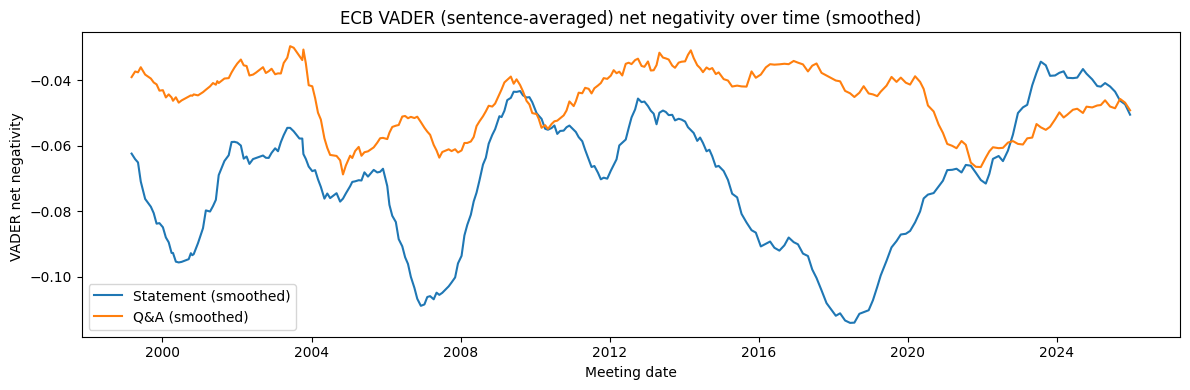

In [ ]:
# graph to see statement and q&a negative behaviour over time

df_plot = df.copy()
df_plot["meeting_date"] = pd.to_datetime(df_plot["meeting_date"])
df_plot = df_plot.sort_values("meeting_date")
window = 12

df_plot["stmt_netneg_ma"] = df_plot["vader_stmt_netneg"].rolling(window, min_periods=3).mean()
df_plot["qa_netneg_ma"]   = df_plot["vader_qa_netneg"].rolling(window, min_periods=3).mean()

plt.figure(figsize=(12,4))

# Smoothed series
plt.plot(df_plot["meeting_date"], df_plot["stmt_netneg_ma"], label="Statement (smoothed)")
plt.plot(df_plot["meeting_date"], df_plot["qa_netneg_ma"], label="Q&A (smoothed)")

plt.title("ECB VADER (sentence-averaged) net negativity over time (smoothed)")
plt.xlabel("Meeting date")
plt.ylabel("VADER net negativity ") # (neg_avg - pos_avg)
plt.legend()
plt.tight_layout()
plt.show()
#statements tend to be more positive (lower netneg) on average

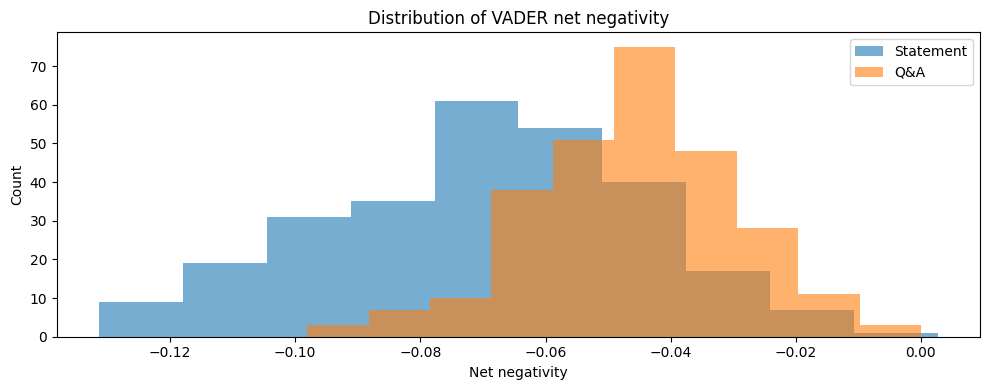

In [ ]:
# they're not the same
plt.figure(figsize=(10,4))
plt.hist(df_plot["vader_stmt_netneg"].dropna(), alpha=0.6, label="Statement")
plt.hist(df_plot["vader_qa_netneg"].dropna(), alpha=0.6, label="Q&A")
plt.title("Distribution of VADER net negativity")
plt.xlabel("Net negativity")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()

# Compute CAR

In [ ]:
# CAR
# Load stoxx 50 abs prices
stoxx_Path = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Stoxx50_Absolute.xlsx"
stoxx = pd.read_excel(stoxx_Path)
print(stoxx.columns)
prices = stoxx.rename(columns={"Date": "date", "Close": "close"}).copy()


Index(['Date', 'Close'], dtype='object')


In [ ]:
prices["date"] = pd.to_datetime(prices["date"], dayfirst=True, errors="coerce")
prices["close"] = pd.to_numeric(prices["close"], errors="coerce")
prices = prices.dropna(subset=["date", "close"]).sort_values("date")
prices = prices.sort_values("date").reset_index(drop=True)
prices.describe()


,date,close
count,10058,10058.000000
mean,2006-06-10 08:55:44.442235008,2659.493310
min,1986-12-31 00:00:00,626.090000
25%,1996-08-20 06:00:00,1630.977500
50%,2006-06-01 12:00:00,2817.145000
75%,2016-03-17 18:00:00,3438.007500
max,2026-01-02 00:00:00,5183.240000
std,NaN,1117.535184


In [ ]:
import numpy as np
window_value_abret = {}
window_car = {}
prices['ret'] = np.log(prices['close']).diff()
# Expected return
prices['expected_ret'] = prices['ret'].shift(50).rolling(window=201).mean()
# dif
prices['abnormal_return'] = prices['ret'] - prices['expected_ret']
# 11 Days
prices["CAR"] = prices["abnormal_return"].rolling(window=11, center=True).sum()

prices.head()
prices[["date","close","ret","expected_ret","abnormal_return","CAR"]].dropna().head(3)


,date,close,ret,expected_ret,abnormal_return,CAR
256,1987-12-24,679.30,0.001473,0.000692,0.000781,-0.011990
257,1987-12-25,679.30,0.000000,0.000677,-0.000677,-0.014831
258,1987-12-28,680.28,0.001442,0.000257,0.001185,-0.016998


In [ ]:
df_clean

,meeting_date,url,title,title_lower
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement
...,...,...,...,...
269,2025-06-05,https://www.ecb.europa.eu/press/press_conferen...,Monetary policy statement (with Q&A),monetary policy statement (with q&a)
270,2025-07-24,https://www.ecb.europa.eu/press/press_conferen...,Monetary policy statement (with Q&A),monetary policy statement (with q&a)
271,2025-09-11,https://www.ecb.europa.eu/press/press_conferen...,Monetary policy statement (with Q&A),monetary policy statement (with q&a)
272,2025-10-30,https://www.ecb.europa.eu/press/press_conferen...,Monetary policy statement (with Q&A),monetary policy statement (with q&a)


In [ ]:
#merge data
df_clean = df_clean.merge(
    prices[["date", "CAR"]],
    left_on="meeting_date",
    right_on="date",
    how="left"
).drop(columns=["date"])


In [ ]:
# inflation
inf_Path = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/inflation_1999_2025.csv"
inflation_df = pd.read_csv(inf_Path)


In [ ]:
inflation_df["date"] = pd.to_datetime(inflation_df["date"])
inflation_df = inflation_df.sort_values("date")

# Ensure the inflation column from inflation_df has a unique name before merging
df_clean = pd.merge_asof(
    df_clean,
    inflation_df[["date","inflation"]].rename(columns={"date":"meeting_date", "inflation":"monthly_inflation"}),
    on="meeting_date",
    direction="backward"
)
# lag inflation
df_clean["inflation_lag1"] = df_clean["monthly_inflation"].shift(1)

df_clean.head()

,meeting_date,url,title,title_lower,CAR,monthly_inflation,inflation_lag1
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.008932,0.704980,NaN
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.020224,0.889010,0.704980
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.001901,0.957756,0.889010
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.026047,1.027533,0.957756
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.023142,0.998168,1.027533


In [ ]:
# until here we have inflation so lets add output gap
import pandas as pd
gap_Path = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Output_gap.xlsx"
gap_df = pd.read_excel(gap_Path)



In [ ]:
mro_Path = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/MRO_announcements.xlsx"
mro_df = pd.read_excel(mro_Path)
# Daily date
mro_df["date"] = pd.to_datetime(mro_df["t_allot_dt"], errors="coerce").dt.normalize()

# marginal and fixed rate as numeric
for c in ["t_marginal_rate", "t_fixed_rate"]:
    mro_df[c] = pd.to_numeric(mro_df[c], errors="coerce")

# Prefer marginal; if missing, use fixed
mro_df["mro_rate"] = mro_df["t_marginal_rate"].combine_first(mro_df["t_fixed_rate"])
mro_daily = (
    mro_df.dropna(subset=["date", "mro_rate"])
      .sort_values(["date", "t_allot_dt"])
      .groupby("date", as_index=False)["mro_rate"]
      .last()
)

mro_daily.head()

,date,mro_rate
0,1999-01-05,3.0
1,1999-01-12,3.0
2,1999-01-19,3.0
3,1999-01-26,3.0
4,1999-02-02,3.0


In [ ]:
mro_daily["mro_rate"] = mro_daily["mro_rate"].diff().fillna(0)


In [ ]:
# merge in clean df by meeting date
df_clean = pd.merge_asof(
    df_clean,
    mro_daily.rename(columns={"date": "meeting_date"})[["meeting_date", "mro_rate"]],
    on="meeting_date",
    direction="backward"
)

df_clean.head()

,meeting_date,url,title,title_lower,CAR,monthly_inflation,inflation_lag1,mro_rate
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.008932,0.704980,NaN,0.0
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.020224,0.889010,0.704980,0.0
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.001901,0.957756,0.889010,0.0
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.026047,1.027533,0.957756,0.0
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.023142,0.998168,1.027533,0.0


In [ ]:
df_clean[["meeting_date", "mro_rate"]].head()

,meeting_date,mro_rate
0,1999-01-07,0.0
1,1999-02-04,0.0
2,1999-03-04,0.0
3,1999-04-08,0.0
4,1999-05-06,0.0


In [ ]:
# output - euro area output gap (% of potential GDP)lagged by one year to mitigate look ahead bias.
output_Path = "/content/drive/MyDrive/FTD/DATAscience/PROJECT_ECB/Output_gap.xlsx"
outputgap_df = pd.read_excel(output_Path)
# columns into date and gap
outputgap_df = outputgap_df.rename(columns={outputgap_df.columns[0]:"year",
                                            outputgap_df.columns[1]:"output_gap"})
# numeric
outputgap_df["year"] = pd.to_numeric(outputgap_df["year"], errors="coerce").astype("Int64")
outputgap_df["output_gap"] = pd.to_numeric(outputgap_df["output_gap"], errors="coerce")

outputgap_df = outputgap_df.dropna(subset=["year"]).sort_values("year")
#create lags
outputgap_df["output_gap_lag1y"] = outputgap_df["output_gap"].shift(1)

# Add 'year' column to df_clean for merging
df_clean["year"] = pd.to_datetime(df_clean["meeting_date"]).dt.year

df_clean = df_clean.merge(outputgap_df[["year","output_gap_lag1y"]],
                          on="year",
                          how="left",
                          suffixes=("", "_from_outputgap"))

if 'output_gap_lag1y_from_outputgap' in df_clean.columns:
    df_clean['output_gap_lag1y'] = df_clean['output_gap_lag1y_from_outputgap']
    df_clean = df_clean.drop(columns=['output_gap_lag1y_from_outputgap'])

df_clean["output_gap_lag1y"] = df_clean["output_gap_lag1y"].ffill()

df_clean.head()

,meeting_date,url,title,title_lower,CAR,monthly_inflation,inflation_lag1,mro_rate,year,output_gap_lag1y
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.008932,0.704980,NaN,0.0,1999,-0.127149
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.020224,0.889010,0.704980,0.0,1999,-0.127149
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.001901,0.957756,0.889010,0.0,1999,-0.127149
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,0.026047,1.027533,0.957756,0.0,1999,-0.127149
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,ecb press conference: introductory statement,-0.023142,0.998168,1.027533,0.0,1999,-0.127149


In [ ]:

# 1. Load ecb_monetary_policy_statements_all_years.csv into df_clean_economic_indicators
df_clean_economic_indicators = pd.read_csv("ecb_monetary_policy_statements_all_years.csv")

df_clean_economic_indicators.head()

,meeting_date,url,title
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement


In [ ]:
df_clean_economic_indicators['meeting_date']=pd.to_datetime(df_clean_economic_indicators['meeting_date'])
df_clean_economic_indicators = df_clean_economic_indicators.merge(
    prices[["date","ret","expected_ret","abnormal_return","CAR",]],
    left_on="meeting_date",
    right_on="date",
    how="left"
).drop(columns=["date"])


In [ ]:
inflation_df_temp = inflation_df.copy()
inflation_df_temp = inflation_df_temp.rename(columns={"date": "meeting_date", "inflation": "monthly_inflation"})

df_clean_economic_indicators = pd.merge_asof(
    df_clean_economic_indicators,
    inflation_df_temp[["meeting_date", "monthly_inflation"]],
    on="meeting_date",
    direction="backward"
)
df_clean_economic_indicators["inflation_lag1"] = df_clean_economic_indicators["monthly_inflation"].shift(1)

df_clean_economic_indicators.head()

,meeting_date,url,title,ret,expected_ret,abnormal_return,CAR,monthly_inflation,inflation_lag1
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.013899,0.000368,-0.014267,-0.008932,0.704980,NaN
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.000819,0.000636,0.000183,-0.020224,0.889010,0.704980
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.013099,0.000351,0.012748,0.001901,0.957756,0.889010
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.004670,0.000079,0.004591,0.026047,1.027533,0.957756
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.002709,0.000262,-0.002971,-0.023142,0.998168,1.027533


In [ ]:
mro_daily_temp = mro_daily.copy()
mro_daily_temp = mro_daily_temp.rename(columns={"date": "meeting_date"})

df_clean_economic_indicators = pd.merge_asof(
    df_clean_economic_indicators,
    mro_daily_temp[["meeting_date", "mro_rate"]],
    on="meeting_date",
    direction="backward"
)

df_clean_economic_indicators.head()

,meeting_date,url,title,ret,expected_ret,abnormal_return,CAR,monthly_inflation,inflation_lag1,mro_rate
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.013899,0.000368,-0.014267,-0.008932,0.704980,NaN,0.0
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.000819,0.000636,0.000183,-0.020224,0.889010,0.704980,0.0
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.013099,0.000351,0.012748,0.001901,0.957756,0.889010,0.0
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.004670,0.000079,0.004591,0.026047,1.027533,0.957756,0.0
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.002709,0.000262,-0.002971,-0.023142,0.998168,1.027533,0.0


In [ ]:
outputgap_df_temp = outputgap_df.copy()

outputgap_df_temp = outputgap_df_temp.dropna(subset=["year"])[["year", "output_gap_lag1y"]]

# Add 'year' column to df_clean_economic_indicators for merging
df_clean_economic_indicators["year"] = df_clean_economic_indicators["meeting_date"].dt.year

df_clean_economic_indicators = df_clean_economic_indicators.merge(
    outputgap_df_temp,
    on="year",
    how="left"
)

# Fill any missing output_gap_lag1y values using forward fill
df_clean_economic_indicators["output_gap_lag1y"] = df_clean_economic_indicators["output_gap_lag1y"].ffill()

print("Output gap (lagged by 1 year) merged and forward-filled into df_clean_economic_indicators.")
df_clean_economic_indicators.head()

Output gap (lagged by 1 year) merged and forward-filled into df_clean_economic_indicators.


,meeting_date,url,title,ret,expected_ret,abnormal_return,CAR,monthly_inflation,inflation_lag1,mro_rate,year,output_gap_lag1y
0,1999-01-07,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.013899,0.000368,-0.014267,-0.008932,0.704980,NaN,0.0,1999,-0.127149
1,1999-02-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.000819,0.000636,0.000183,-0.020224,0.889010,0.704980,0.0,1999,-0.127149
2,1999-03-04,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.013099,0.000351,0.012748,0.001901,0.957756,0.889010,0.0,1999,-0.127149
3,1999-04-08,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,0.004670,0.000079,0.004591,0.026047,1.027533,0.957756,0.0,1999,-0.127149
4,1999-05-06,https://www.ecb.europa.eu/press/press_conferen...,ECB Press conference: Introductory statement,-0.002709,0.000262,-0.002971,-0.023142,0.998168,1.027533,0.0,1999,-0.127149


# Regression
* df_regression

In [ ]:

# Calculate statement and Q&A similarity on the main df
# The function compute_similarity_series_from_sets is defined earlier in the notebook
df["statement_similarity"] = compute_similarity_series_from_sets(df["bigrams_statement"])
df["qa_similarity"] = compute_similarity_series_from_sets(df["bigrams_qa"])

# Convert similarity columns to numeric
df["statement_similarity"] = pd.to_numeric(df["statement_similarity"], errors="coerce")
df["qa_similarity"] = pd.to_numeric(df["qa_similarity"], errors="coerce")

# Now, create df_regression by merging df (which now has similarities) with economic indicators
df_regression = df.merge(
    df_clean_economic_indicators.drop(columns=["url", "title", "year"], errors='ignore'), # Avoid merging redundant columns and handle 'year' if it was transient
    on="meeting_date",
    how="left"
)

# No print statement, as per previous request
df_regression.head()

ValueError: You are trying to merge on object and datetime64[ns] columns for key 'meeting_date'. If you wish to proceed you should use pd.concat

In [ ]:
print(df_regression.head())
print(df_regression.describe())

In [ ]:
#Add missing variables after df_regression is created
cols_num = ["output_gap_lag1y", "inflation_lag1", "mro_rate", "CAR",
            "statement_similarity", "qa_similarity", "pessimism",
            "vader_stmt_netneg", "vader_qa_netneg"
            ]
for c in cols_num:
    if c not in df_regression.columns:
        df_regression[c] = pd.to_numeric(df_regression[c], errors="coerce")

## Transform variables
* absolute CAR
* log for similarity
* time variables
* interaction terms

In [ ]:
#Absolute CAR
df_regression["abs_CAR"] = df_regression["CAR"].abs()

#log transformation for similarity
df_regression["log_statement_similarity"] = np.log(df_regression['statement_similarity'].replace(0, np.nan))
df_regression["log_qa_similarity"]=np.log(df_regression['qa_similarity'].replace(0, np.nan))
#time variables
df_regression["time_days"]=(df_regression['meeting_date'] - df_regression['meeting_date'].min()).dt.days
df_regression['log_time'] = np.log(df_regression['time_days'] + 1)

#interaction terms
df_regression['pessimism_x_log_similarity'] = df_regression['pessimism'] * df_regression['log_statement_similarity']
df_regression['pessimism_x_log_qa_similarity'] = df_regression['pessimism'] * df_regression['log_qa_similarity']

In [ ]:
import statsmodels.api as sm

def fit_linear_regression(y, x, cov_type="HC1"):


    # na droppinf
    data = pd.concat([y.rename("y"), x], axis=1).dropna()
    y_clean = data["y"]
    x_clean = data.drop(columns=["y"])

    # Constant
    x_clean = sm.add_constant(x_clean)

    # OLS (robust error)
    model = sm.OLS(y_clean, x_clean).fit(cov_type=cov_type)

    print(model.summary())
    return model


In [ ]:
#filter only till 2013 for replication
df_1999_2013 = df_regression[df_regression['meeting_date'] <= '2013-12-31'].copy()

# Table 3 replication
Does ECB similarity increase over time ?

In [ ]:
y=df_1999_2013['log_statement_similarity']

#model 1 x Only economic controls (Output gap, Inflation, Delta MRO)
x=df_1999_2013[[ 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_1=fit_linear_regression(y,x)

#model 2 Time + NO economic controls
x = df_1999_2013[['log_time']]
model_table3_2 = fit_linear_regression(y, x)

#model 3 Time + economic controls
x = df_1999_2013[['log_time', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_3 = fit_linear_regression(y, x)

#model 4 Time(count) + economic controls
df_1999_2013["time_count"]=range(1,len(df_1999_2013)+1)
df_1999_2013["log_time_count"]=np.log(df_1999_2013["time_count"])

x=df_1999_2013[['log_time_count', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_4=fit_linear_regression(y,x)


# Table 4 replication

* Explaining Absolute CAR

In [ ]:
y=df_1999_2013['abs_CAR']

#model 1: only pessimism
x=df_1999_2013["pessimism"]
model_table4_1=fit_linear_regression(y,x)

#model 2:only economic controls
x=df_1999_2013[["output_gap_lag1y","inflation_lag1","mro_rate"]]
model_table4_2=fit_linear_regression(y,x)

#model 3: Interaction term
x=df_1999_2013[['pessimism_x_log_similarity']]
model_table4_3=fit_linear_regression(y,x)

#model 4:Interaction term + economic controls
x=df_1999_2013[['pessimism_x_log_similarity', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table4_4=fit_linear_regression(y,x)

#model 5: Interaction term + economic controls + SURPRISE MRO(?????)


# Extension analysis

In [ ]:
#1999-2013 vs 2014-2025
df_replication = df_regression[df_regression['meeting_date'] <= '2013-12-31'].copy()
df_extension = df_regression[df_regression['meeting_date'] > '2013-12-31'].copy()

#descriptive statistics
desc_vars = ['CAR', 'abs_CAR', 'pessimism', 'statement_similarity',
             'output_gap_lag1y', 'inflation_lag1', 'mro_rate']
print(df_replication[desc_vars].describe().T[["mean","std","min","max"]].round(3))
print(df_extension[desc_vars].describe().T[["mean","std","min","max"]].round(3))


##table 3 2014-2025 + full sample

In [ ]:
#extension
y=df_extension['log_statement_similarity']

#model 1 x Only economic controls (Output gap, Inflation, Delta MRO)
x=df_extension[[ 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_1=fit_linear_regression(y,x)

#model 2 Time + NO economic controls
x = df_extension[['log_time']]
model_table3_2 = fit_linear_regression(y, x)

#model 3 Time + economic controls
x = df_extension[['log_time', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_3 = fit_linear_regression(y, x)

#model 4 Time(count) + economic controls
df_extension["time_count"]=range(1,len(df_extension)+1)
df_extension["log_time_count"]=np.log(df_extension["time_count"])

x=df_extension[['log_time_count', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_4=fit_linear_regression(y,x)

table 3 full sample

In [ ]:
#full sample
y=df_regression['log_statement_similarity']

#model 1 x Only economic controls (Output gap, Inflation, Delta MRO)
x=df_regression[[ 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_1=fit_linear_regression(y,x)

#model 2 Time + NO economic controls
x = df_regression[['log_time']]
model_table3_2 = fit_linear_regression(y, x)

#model 3 Time + economic controls
x = df_regression[['log_time', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_3 = fit_linear_regression(y, x)

#model 4 Time(count) + economic controls
df_regression["time_count"]=range(1,len(df_regression)+1)
df_regression["log_time_count"]=np.log(df_regression["time_count"])

x=df_regression[['log_time_count', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_4=fit_linear_regression(y,x)

## Table 4 extension

In [ ]:
#extension
y=df_extension['abs_CAR']

#model 1: only pessimism
x=df_extension["pessimism"]
model_table4_1=fit_linear_regression(y,x)

#model 2:only economic controls
x=df_extension[["output_gap_lag1y","inflation_lag1","mro_rate"]]
model_table4_2=fit_linear_regression(y,x)

#model 3: Interaction term
x=df_extension[['pessimism_x_log_similarity']]
model_table4_3=fit_linear_regression(y,x)

#model 4:Interaction term + economic controls
x=df_extension[['pessimism_x_log_similarity', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table4_4=fit_linear_regression(y,x)

#model 5: Interaction term + economic controls + SURPRISE MRO(?????)


full sample

In [ ]:
#full sample
y=df_regression['abs_CAR']

#model 1: only pessimism
x=df_regression["pessimism"]
model_table4_1=fit_linear_regression(y,x)

#model 2:only economic controls
x=df_regression[["output_gap_lag1y","inflation_lag1","mro_rate"]]
model_table4_2=fit_linear_regression(y,x)

#model 3: Interaction term
x=df_regression[['pessimism_x_log_similarity']]
model_table4_3=fit_linear_regression(y,x)

#model 4:Interaction term + economic controls
x=df_regression[['pessimism_x_log_similarity', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table4_4=fit_linear_regression(y,x)

#model 5: Interaction term + economic controls + SURPRISE MRO(?????)

#Extension: Q&A analysis

In [ ]:
print(df_regression.columns)

In [ ]:
#full sample
y=df_regression['log_qa_similarity']

#model 1 x Only economic controls (Output gap, Inflation, Delta MRO)
x=df_regression[[ 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_1=fit_linear_regression(y,x)

#model 2 Time + NO economic controls
x = df_regression[['log_time']]
model_table3_2 = fit_linear_regression(y, x)

#model 3 Time + economic controls
x = df_regression[['log_time', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_3 = fit_linear_regression(y, x)

#model 4 Time(count) + economic controls
df_regression["time_count"]=range(1,len(df_regression)+1)
df_regression["log_time_count"]=np.log(df_regression["time_count"])

x=df_regression[['log_time_count', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table3_4=fit_linear_regression(y,x)

In [ ]:
#full sample
y=df_regression['abs_CAR']

# #model 1: only pessimism
# x=df_regression["pessimism"]
# model_table4_1=fit_linear_regression(y,x)

# #model 2:only economic controls
# x=df_regression[["output_gap_lag1y","inflation_lag1","mro_rate"]]
# model_table4_2=fit_linear_regression(y,x)

# #model 3: Interaction term
# x=df_regression[['pessimism']]
# model_table4_3=fit_linear_regression(y,x)

#model 4:Interaction term + economic controls
x=df_regression[['pessimism_x_log_qa_similarity', 'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_table4_4=fit_linear_regression(y,x)

#model 5: Interaction term + economic controls + SURPRISE MRO(?????)

In [ ]:
#QA vs statement: side by side comparison
y=df_regression["abs_CAR"]
x=df_regression[['pessimism_x_log_similarity', 'pessimism_x_log_qa_similarity',
                   'output_gap_lag1y', 'inflation_lag1', 'mro_rate']]
model_qa_stm=fit_linear_regression(y,x)

# Extension: "Horse race"
Does VADER add information beyond LM? And does tone change the effect of similarity?

* LM is finance-based
* VADER is general sentiment
* A horse race would test whether the extension is real or just noise



In [ ]:
print(df_regression.columns)

In [ ]:
#data prep
import statsmodels.api as sm

reg=df_regression.copy()

reg=reg.dropna(subset=["abs_CAR","statement_similarity","pessimism","vader_stmt_compound"]).copy()

reg=reg.sort_values('date')
reg["dvader"]=reg["vader_stmt_compound"].diff()
reg["dpess"]=reg["pessimism"].diff()


In [ ]:
y=reg["abs_CAR"]

#VADER only
X_v=sm.add_constant(reg[["log_statement_similarity","vader_stmt_compound"]])
m_v=sm.OLS(y,X_v).fit(cov_type="HAC",cov_kwds={"maxlags":4})

#LM only
X_lm=sm.add_constant(reg[["log_statement_similarity","pessimism"]])
m_lm=sm.OLS(y,X_lm).fit(cov_type="HAC",cov_kwds={"maxlags":4})

#Horse race
X_hr=sm.add_constant(reg[["log_statement_similarity","pessimism","vader_stmt_compound"]])
m_hr=sm.OLS(y,X_hr).fit(cov_type="HAC",cov_kwds={"maxlags":4})

#Interaction (similarity x VADER)
reg["sim_x_vader"]=reg["log_statement_similarity"]*reg["vader_stmt_compound"]
X_int=sm.add_constant(reg[["log_statement_similarity","vader_stmt_compound","sim_x_vader"]])
m_int=sm.OLS(y,X_int).fit(cov_type="HAC",cov_kwds={"maxlags":4})

print("VADER-only:\n",m_v.summary())
print("LM-only:\n",m_lm.summary())
print("Horse race:\n",m_hr.summary())
print("Interaction:\n",m_int.summary())

#Extension: predict high-volatility meetings
make it a prediction task, not just inference

*high_impact=1 if abs_CAR > 75th percentile else 0

In [ ]:
q75=df_regression["abs_CAR"].quantile(0.75)
df_regression["high_impact"]=np.where(df_regression["abs_CAR"]>q75,1,0)

df_regression["high_impact"].value_counts(normalize=True)

In [ ]:
#features
features=[
    #similarity
    "log_statement_similarity",
    "log_qa_similarity",

    #LM
    "pessimism",

    #VADER (statement)
    "vader_stmt_compound",

    #VADER (Q&A)
    "vader_qa_compound",
]

ml_df=df_regression.dropna(subset=features+["high_impact"]).copy()

X=ml_df[features]
y=ml_df["high_impact"]

X.shape, y.mean()

In [ ]:
train=ml_df[ml_df["date"]<="2013-12-31"]
test=ml_df[ml_df["date"]>'2013-12-31']

X_train=train[features]
y_train=train["high_impact"]

X_test=test[features]
y_test=test["high_impact"]

len(train),len(test)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score, classification_report

pipe_logit=Pipeline([
    ("scaler",StandardScaler()),
    ("logit",LogisticRegression(max_iter=1000))
])

pipe_logit.fit(X_train,y_train)

y_pred_prob=pipe_logit.predict_proba(X_test)[:,1]
y_pred=pipe_logit.predict(X_test)

print("AUC:",roc_auc_score(y_test,y_pred_prob))
print(classification_report(y_test,y_pred))

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=4)

rf.fit(X_train,y_train)

rf_prob=rf.predict_proba(X_test)[:,1]
print("RF-AUC:",roc_auc_score(y_test,rf_prob))
print(classification_report(y_test,y_pred))